## Import Dependencies

In [89]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import timedelta
import calendar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, RepeatVector, Concatenate, Bidirectional, LSTM,Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers


## Import Dataset

In [39]:
url = 'https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk'
gdown.download(url, 'weather.csv', quiet=False)
df = pd.read_csv('weather.csv')


Downloading...
From (original): https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk
From (redirected): https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk&confirm=t&uuid=dc6d252d-d618-487d-9d66-8e3deef9ecb3
To: d:\KULI\SEM 6\DBS\Capstone\HiPlan-ML\weather-prediction-model\weather.csv
100%|██████████| 132M/132M [00:22<00:00, 5.96MB/s] 


In [46]:
df.head(5)

,datetime,datetimeepoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,description,icon,stations,source,kecamatan,severerisk,day,month,weekday,year
0,2020-01-01,1577811600,31.1,20.6,24.8,36.9,20.6,26.0,22.0,85.6,...,partly cloudy throughout the day with rain in ...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,1,1,2,2020
1,2020-01-02,1577898000,33.2,19.2,24.7,39.3,19.2,25.8,21.2,82.5,...,partly cloudy throughout the day with late aft...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,2,1,3,2020
2,2020-01-03,1577984400,31.7,20.8,24.4,39.6,20.8,25.5,22.3,88.7,...,partly cloudy throughout the day with late aft...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,3,1,4,2020
3,2020-01-04,1578070800,31.2,20.4,24.4,39.1,20.4,25.5,22.0,87.3,...,partly cloudy throughout the day with afternoo...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,4,1,5,2020
4,2020-01-05,1578157200,31.2,20.6,25.0,37.4,20.6,26.2,22.0,84.7,...,partly cloudy throughout the day with early mo...,rain,"['96073099999', 'remote']",obs,angkola timur,10.0,5,1,6,2020


## Preprocessing

In [47]:
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [49]:
df['datetime'] = pd.to_datetime(df['datetime'])

## Feature Engineering

In [50]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day_of_year'] = df['datetime'].dt.dayofyear

In [51]:
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 366)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 366)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

## Define Features and Targets

In [52]:
numerical_features = ['year', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
categorical_features = ['kecamatan']

features = numerical_features + categorical_features
targets = ['precipprob', 'windspeed', 'temp', 'humidity']

In [53]:
X = df[features]
y = df[targets]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessors Pipeline

In [58]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [60]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [61]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Model Building

In [62]:
input_shape = X_train_processed.shape[1]
input_layer = Input(shape=(input_shape,), name='input')

x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

output_layer = Dense(4, name='output')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 201)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,324 (141.89 KB)

 Trainable params: 36,324 (141.89 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
9269/9269 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 218.1828 - mae: 6.2368 - val_loss: 220.2879 - val_mae: 6.1686
Epoch 2/100
9269/9269 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 216.1494 - mae: 6.1953 - val_loss: 219.9686 - val_mae: 6.1754
Epoch 3/100
9269/9269 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 216.6078 - mae: 6.2173 - val_loss: 219.7194 - val_mae: 6.0912
Epoch 4/100
9269/9269 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 214.9247 - mae: 6.1659 - val_loss: 220.4095 - val_mae: 6.1807
Epoch 5/100
9269/9269 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 216.4733 - mae: 6.2084 - val_loss: 219.4431 - val_mae: 6.1525
Epoch 6/100
9269/9269 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 215.2203 - mae: 6.1789 - val_loss: 220.9790 - val_mae: 6.2271
Epoch 7/100
9269/9269 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 215.9449 - mae: 6.1925 - val_loss: 220.5403 - val_mae: 5.9304
Epoch 8/100
9269/9269 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 215.8958 - mae: 6.1849 - val_loss: 221.4294 - val_mae:

## Model Evaluation

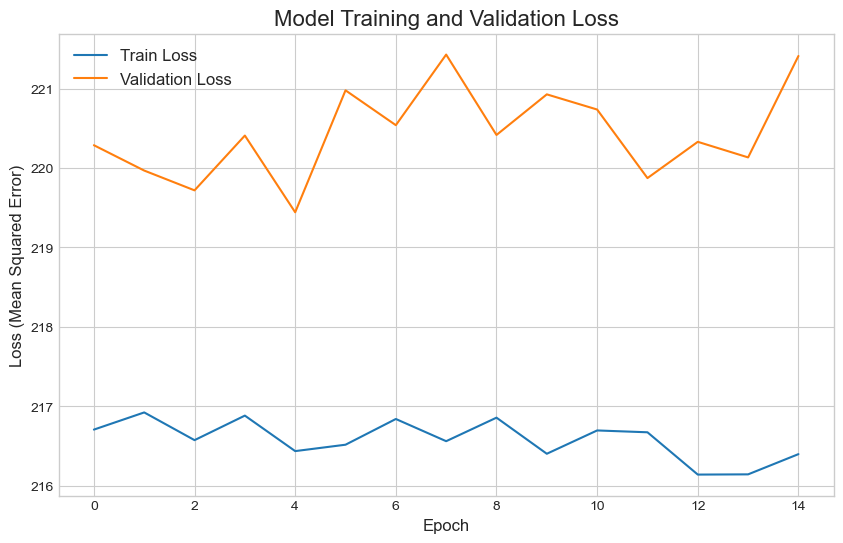

In [68]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')

ax.set_title('Model Training and Validation Loss', fontsize=16)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (Mean Squared Error)', fontsize=12)
ax.legend(fontsize=12)

plt.show()

In [69]:
y_pred = model.predict(X_test_processed)

for i, target_name in enumerate(targets):
    print(f"\nMetrics for {target_name}:")
    
    y_true_target = y_test[target_name]
    y_pred_target = y_pred[:, i]
    
    mse = mean_squared_error(y_true_target, y_pred_target)
    mae = mean_absolute_error(y_true_target, y_pred_target)
    r2 = r2_score(y_true_target, y_pred_target)
    
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²):           {r2:.4f}")

2318/2318 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

Metrics for precipprob:
  Mean Squared Error (MSE): 828.7054
  Mean Absolute Error (MAE): 16.7692
  R-squared (R²):           0.3271

Metrics for windspeed:
  Mean Squared Error (MSE): 26.3666
  Mean Absolute Error (MAE): 3.3758
  R-squared (R²):           0.5268

Metrics for temp:
  Mean Squared Error (MSE): 1.7450
  Mean Absolute Error (MAE): 0.9769
  R-squared (R²):           0.8148

Metrics for humidity:
  Mean Squared Error (MSE): 20.9546
  Mean Absolute Error (MAE): 3.4879
  R-squared (R²):           0.5545


## Save Model

In [70]:
SEASONAL_MODEL_PATH = 'weather_seasonal_model.keras'
SEASONAL_PREPROCESSOR_PATH = 'weather_seasonal_preprocessor.pkl'

model.save(SEASONAL_MODEL_PATH)

with open(SEASONAL_PREPROCESSOR_PATH, 'wb') as f:
    pickle.dump(preprocessor, f)

print("Seasonal model and preprocessor saved.")

Seasonal model and preprocessor saved.


## Testing

In [ ]:
def predict_weather_range(kecamatan_name: str, start_date_str: str, days_to_predict: int):

    # load model and preprocessor
    try:
        model = tf.keras.models.load_model(SEASONAL_MODEL_PATH)
        with open(SEASONAL_PREPROCESSOR_PATH, 'rb') as f:
            preprocessor = pickle.load(f)
    except FileNotFoundError as e:
        return f"Error: Could not load model or preprocessor. Make sure files exist. Details: {e}"

    # generate feature for range
    try:
        start_date = pd.to_datetime(start_date_str)
    except ValueError:
        return "Error: Invalid date format. Please use 'YYYY-MM-DD'."

    features_list = []
    date_range = [start_date + timedelta(days=i) for i in range(days_to_predict)]

    for date in date_range:
        features_list.append({
            'year': date.year,
            'day_sin': np.sin(2 * np.pi * date.dayofyear / 366),
            'day_cos': np.cos(2 * np.pi * date.dayofyear / 366),
            'month_sin': np.sin(2 * np.pi * date.month / 12),
            'month_cos': np.cos(2 * np.pi * date.month / 12),
            'kecamatan': kecamatan_name
        })
    
    input_df = pd.DataFrame(features_list)

    # preprocess and predict
    try:
        input_processed = preprocessor.transform(input_df)
    except Exception as e:
        return f"Error: Could not process input. It's possible the location '{kecamatan_name}' was not in the training data. Error: {e}"

    all_predicted_values = model.predict(input_processed)

    # format output
    final_results = []
    targets = ['precipprob', 'windspeed', 'temp', 'humidity']
    
    for i, date in enumerate(date_range):
        result = {
            'date': date.strftime('%Y-%m-%d'),
            'kecamatan': kecamatan_name,
        }
        predicted_values_for_day = all_predicted_values[i]
        
        for target, value in zip(targets, predicted_values_for_day):
            result[f"predicted_{target}"] = round(float(value), 2)
        
        final_results.append(result)
        
    return final_results

In [ ]:
predict_range = predict_weather_range(
    kecamatan_name="berastagi",
    start_date_str="2025-06-06",
    days_to_predict=3
)

predict_range

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


[{'date': '2025-06-06',
  'kecamatan': 'berastagi',
  'predicted_precipprob': 63.47,
  'predicted_windspeed': 19.22,
  'predicted_temp': 28.2,
  'predicted_humidity': 87.74},
 {'date': '2025-06-07',
  'kecamatan': 'berastagi',
  'predicted_precipprob': 63.52,
  'predicted_windspeed': 19.24,
  'predicted_temp': 28.19,
  'predicted_humidity': 87.78},
 {'date': '2025-06-08',
  'kecamatan': 'berastagi',
  'predicted_precipprob': 63.56,
  'predicted_windspeed': 19.25,
  'predicted_temp': 28.17,
  'predicted_humidity': 87.83}]

In [93]:
def predict_monthly_average(kecamatan_name: str, month: int, year: int):
    """
    Predicts the average seasonal weather for a given month and year.
    """
    # load model and preprocessor
    try:
        model = tf.keras.models.load_model(SEASONAL_MODEL_PATH)
        with open(SEASONAL_PREPROCESSOR_PATH, 'rb') as f:
            preprocessor = pickle.load(f)
    except FileNotFoundError as e:
        return f"Error: Could not load model or preprocessor. Make sure files exist. Details: {e}"

    # month validation
    if not 1 <= month <= 12:
        return "Error: Month must be an integer between 1 and 12."

    # generate feature for days in a month
    start_date_str = f"{year}-{month:02d}-01"
    num_days = calendar.monthrange(year, month)[1]
    date_range = pd.to_datetime([f"{year}-{month:02d}-{day:02d}" for day in range(1, num_days + 1)])

    features_list = []
    for date in date_range:
        features_list.append({
            'year': date.year,
            'day_sin': np.sin(2 * np.pi * date.dayofyear / 366),
            'day_cos': np.cos(2 * np.pi * date.dayofyear / 366),
            'month_sin': np.sin(2 * np.pi * date.month / 12),
            'month_cos': np.cos(2 * np.pi * date.month / 12),
            'kecamatan': kecamatan_name
        })
    
    input_df = pd.DataFrame(features_list)

    # preprocess and predict
    try:
        input_processed = preprocessor.transform(input_df)
    except Exception as e:
        return f"Error: Could not process input for '{kecamatan_name}'. Error: {e}"

    all_predicted_values = model.predict(input_processed)

    # calculate average and format output
    average_values = np.mean(all_predicted_values, axis=0)
    
    targets = ['precipprob', 'windspeed', 'temp', 'humidity']
    result = {
        'year': year,
        'month': calendar.month_name[month],
        'kecamatan': kecamatan_name,
    }
    for target, value in zip(targets, average_values):
        result[f"average_{target}"] = round(float(value), 2)
        
    return result

In [96]:
monthly_forecast = predict_monthly_average(
    kecamatan_name="berastagi",
    month=12,
    year=2026
)

monthly_forecast

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


{'year': 2026,
 'month': 'December',
 'kecamatan': 'berastagi',
 'average_precipprob': 70.26,
 'average_windspeed': 18.57,
 'average_temp': 27.84,
 'average_humidity': 88.85}